<a href="https://colab.research.google.com/github/UmarBalak/AdaptFL/blob/main/AdaptFL_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face code

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import h5py
import torch.nn.functional as F
from torchvision import transforms

class CARLADataset(Dataset):
    def __init__(self, directory, transform=None, one_hot=True, combined_control=False, cache=False):
        """
        Args:
            directory (string): Directory with all the hdf5 files containing the episode data.
            transform (callable, optional): Optional transform to be applied on a sample.
            one_hot (bool): Whether to apply one-hot encoding to high-level commands (hlc) and lights.
            combined_control (bool): Whether to combine throttle and brake control into a single value.
            cache (bool): Whether to cache preprocessed batches.
        """
        self.file_paths = glob.glob(os.path.join(directory, "*.hdf5"))
        if len(self.file_paths) == 0:
            raise FileNotFoundError(f"No .hdf5 files found in the directory {directory}. Please check the path.")

        print(f"Found {len(self.file_paths)} hdf5 files.")

        self.file_paths.sort()  # Ensuring data is processed in order
        self.transform = transform
        self.cache = cache

        self.lengths = []
        self.total_length = 0
        self.files = []
        for file_path in self.file_paths:
            try:
                file = h5py.File(file_path, 'r')
                self.files.append(file)
                length = file['frame'].shape[0]
                self.lengths.append(length)
                self.total_length += length
                print(f"Loaded file: {file_path}, Length: {length}")
            except OSError as e:
                print(f"Error opening file {file_path}: {e}")
                continue

        self.one_hot = one_hot
        self.combined_control = combined_control

        # Optional cache for preprocessed data
        self.cache_data = {} if cache else None

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        print(f"Fetching data for index {idx}")
        if self.cache and idx in self.cache_data:
            return self.cache_data[idx]

        if torch.is_tensor(idx):
            idx = idx.tolist()

        # find the file that contains the data for the given index
        file_idx = 0
        while idx >= self.lengths[file_idx]:
            idx -= self.lengths[file_idx]
            file_idx += 1

        print(f"Using file index {file_idx} for item index {idx}")
        file = self.files[file_idx]

        # Create a dictionary for the data sample
        hlc = torch.tensor(file['hlc'][idx][0], dtype=torch.long)
        light = torch.tensor(file['light'][idx][0], dtype=torch.long)
        if self.one_hot:
            hlc = F.one_hot(hlc.to(torch.int64), num_classes=4)
            light = F.one_hot(light.to(torch.int64), num_classes=4)

        sample = {
            'hlc': hlc,
            'light': light,
            'controls': file['controls'][idx],
            'measurements': torch.tensor(file['measurements'][idx][0], dtype=torch.float32),
            'rgb': torch.tensor(file['rgb'][idx], dtype=torch.float32).permute(2, 0, 1),
            'segmentation': torch.tensor(file['segmentation'][idx], dtype=torch.float32).permute(2, 0, 1)
        }

        # Apply transforms if provided
        if self.transform:
            sample = self.transform(sample)

        # Normalize images and stack RGB with segmentation
        rgb = sample['rgb'] / 255.0
        segmentation = sample['segmentation'] / 255.0
        img = torch.cat((rgb, segmentation), dim=0)

        # Normalize and clip speed measurement
        sample['measurements'] = torch.clamp(sample['measurements'] / 40.0, 0, 1.0).to(torch.float32)

        # Convert steer from [-1, 1] to [0, 1]
        controls = sample['controls']
        if not self.combined_control:
            controls = torch.tensor([controls[0], (controls[1] + 1.0) / 2.0, controls[2]], dtype=torch.float32)
        else:  # combine throttle and brake
            controls = torch.tensor([(controls[0] - controls[2] + 1.0) / 2.0, (controls[1] + 1.0) / 2.0], dtype=torch.float32)

        result = img, sample['measurements'], sample['hlc'], sample['light'], controls

        # Cache preprocessed data if enabled
        if self.cache:
            self.cache_data[idx] = result

        return result

    def __del__(self):
        self.close()

    def close(self):
        for file in self.files:
            file.close()

if __name__ == '__main__':
    data_dir = "/content/"  # Update this to your actual data directory

    # Debug: Check if files are being loaded
    file_paths = glob.glob(os.path.join(data_dir, "*.hdf5"))
    print(f"Found {len(file_paths)} hdf5 files.")

    dataset = CARLADataset(data_dir, cache=False)

    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    num_batches = len(dataloader)
    print(f"Total number of batches: {num_batches}")

    for i, (img_batch, speed_batch, hlc_batch, light_batch, controls_batch) in enumerate(dataloader):
        if i >= num_batches:
            break
        print(f"Batch {i + 1}:")
        print(f"Image batch shape: {img_batch.shape}")


Found 1 hdf5 files.
Found 1 hdf5 files.
Loaded file: /content/episode_0.hdf5, Length: 1419
Total number of batches: 45


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Fetching data for index 0Fetching data for index 32

Using file index 0 for item index 32Using file index 0 for item index 0Fetching data for index 64


Using file index 0 for item index 64
Fetching data for index 96
Using file index 0 for item index 96
Fetching data for index 33Fetching data for index 65
Fetching data for index 97
Fetching data for index 1Using file index 0 for item index 65


Using file index 0 for item index 33Using file index 0 for item index 97
Using file index 0 for item index 1

Fetching data for index 34Fetching data for index 66

Fetching data for index 98
Using file index 0 for item index 34
Using file index 0 for item index 66Using file index 0 for item index 98

Fetching data for index 2
Using file index 0 for item index 2
Fetching data for index 35
Using file index 0 for item index 35Fetching data for index 99
Fetching data for index 67

Using file index 0 for item index 99Fetching data for index 3Using file index 0 for item index 67


Fetching data for in

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import h5py
import torch.nn.functional as F

class CARLADataset(Dataset):
    def __init__(self, directory, transform=None, one_hot=True, combined_control=False):
        """
        Args:
            directory (string): Directory with all the hdf5 files containing the episode data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file_paths = glob.glob(os.path.join(directory, "*.hdf5"))
        self.file_paths.sort()  # Ensuring data is processed in order
        self.transform = transform

        self.lengths = []
        self.total_length = 0
        self.files = []
        for file_path in self.file_paths:
            file = h5py.File(file_path, 'r')
            self.files.append(file)
            length = file['frame'].shape[0]
            self.lengths.append(length)
            self.total_length += length

        self.one_hot = one_hot
        self.combined_control = combined_control

    def __len__(self):
        return self.total_length


    # one hot encoding for high-level ommand
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # find the file that contains the data for the given index
        file_idx = 0
        while idx >= self.lengths[file_idx]:
            idx -= self.lengths[file_idx]
            file_idx += 1

        file = self.files[file_idx]

        # create a dictionary for the data sample
        hlc = torch.tensor(file['hlc'][idx][0], dtype=torch.long)
        light = torch.tensor(file['light'][idx][0], dtype=torch.long)
        if self.one_hot:
            hlc = F.one_hot(hlc.to(torch.int64), num_classes=4)
            light = F.one_hot(light.to(torch.int64), num_classes=4)
        sample = {
            'hlc': hlc,
            'light': light,
            'controls': file['controls'][idx],
            'measurements': torch.tensor(file['measurements'][idx][0], dtype=torch.float32),
            'rgb': torch.tensor(file['rgb'][idx], dtype=torch.float32).permute(2, 0, 1),
            'segmentation': torch.tensor(file['segmentation'][idx], dtype=torch.float32).permute(2, 0, 1)
        }

        if self.transform:
            sample = self.transform(sample)

        # normlize the images and stack RGB with segmentation
        rgb = sample['rgb'] / 255.0
        segmentation = sample['segmentation'] / 255.0
        img = torch.cat((rgb, segmentation), dim=0)

        # normalize and clip speed measurement
        sample['measurements'] = torch.clamp(sample['measurements'] / 40.0, 0, 1.0).to(torch.float32)

        # convert steer from [-1, 1] to [0, 1]
        controls = sample['controls']
        if not self.combined_control:
            controls = torch.tensor([controls[0], (controls[1]+ 1.0) / 2.0, controls[2]], dtype=torch.float32)
        else: # combine throttle and brake
            controls = torch.tensor([(controls[0] - controls[2] + 1.0) / 2.0, (controls[1]+ 1.0) / 2.0], dtype=torch.float32)

        return img, sample['measurements'], sample['hlc'], sample['light'], controls

    def close(self):
        for file in self.files:
            file.close()

if __name__ == '__main__':
    # Set the directory where your .pkl files are
    data_dir = "/content/"

    # Create the dataset
    dataset = CARLADataset(data_dir)
    print(len(dataset))
    # Create the dataloader
    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) #set shuffle=False to take advantage of caching

    # Get a batch of data
    img_batch, speed_batch, hlc_batch, light_batch, controls_batch = next(iter(dataloader)) # unpack the 5 returned values

    # Check the shapes of the data
    print("Image batch shape:", img_batch.shape)
    print("Speed batch shape:", speed_batch.shape)
    print("Controls batch shape:", controls_batch.shape)

    # Check the range of values in the image batch (should be [0, 1])
    print("Image batch min:", img_batch.min().item())
    print("Image batch max:", img_batch.max().item())

    # Check the range of values in the speed batch (should be [0, 1])
    print("Speed batch min:", speed_batch.min().item())
    print("Speed batch max:", speed_batch.max().item())

    # Check the range of values in the speed batch (should be [0, 1])
    print("HLC batch min:",hlc_batch.min().item())
    print("HLC batch max:", hlc_batch.max().item())

    # Check the range of values in the controls batch
    print("Controls batch min:", controls_batch.min().item())
    print("Controls batch max:", controls_batch.max().item())

1419
Image batch shape: torch.Size([32, 6, 200, 288])
Speed batch shape: torch.Size([32])
Controls batch shape: torch.Size([32, 3])
Image batch min: 0.0
Image batch max: 1.0
Speed batch min: 0.03223826736211777
Speed batch max: 0.8612362146377563
HLC batch min: 0
HLC batch max: 1
Controls batch min: 0.0
Controls batch max: 0.8500000238418579


# Data Loading and Preprocessing

## Step 1: Load the Data

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the HDF5 file
def load_episode_data(filepath):
    with h5py.File(filepath, 'r') as f:
        data = {
            'frame': f['frame'][:],
            'hlc': f['hlc'][:],
            'light': f['light'][:],
            'controls': f['controls'][:],  # throttle, steer, brake
            'measurements': f['measurements'][:],  # speed
            'rgb': f['rgb'][:],  # raw RGB image data
            'segmentation': f['segmentation'][:]  # segmentation masks
        }
    return data

# Load episode data
episode_data = load_episode_data('/content/episode_0.hdf5')


In [ ]:
len(episode_data)

7

## Step 2: Analyze the Data

### 2.1: Explore Dataset Fields

In [ ]:
def analyze_data(data):
    print("Number of frames:", len(data['frame']))
    print("HLC shape:", data['hlc'].shape)
    print("Controls shape (Throttle, Steer, Brake):", data['controls'].shape)
    print("Measurements (Speed):", data['measurements'].shape)
    print("RGB Image shape:", data['rgb'].shape)
    print("Segmentation Image shape:", data['segmentation'].shape)

    # Check unique high-level commands (HLC)
    unique_hlc = np.unique(data['hlc'])
    print("Unique high-level commands (HLC):", unique_hlc)

    # Check traffic light statuses
    unique_lights = np.unique(data['light'])
    print("Unique traffic light statuses:", unique_lights)

# Run analysis
analyze_data(episode_data)


Number of frames: 1419
HLC shape: (1419, 1)
Controls shape (Throttle, Steer, Brake): (1419, 3)
Measurements (Speed): (1419, 1)
RGB Image shape: (1419, 200, 288, 3)
Segmentation Image shape: (1419, 200, 288, 3)
Unique high-level commands (HLC): [0 1 2 3]
Unique traffic light statuses: [0 1 2]


### 2.2: Visualize the Data

Exception ignored in: <function CARLADataset.__del__ at 0x7ca6058d5510>
Traceback (most recent call last):
  File "<ipython-input-17-c6a121fe3209>", line 114, in __del__
  File "<ipython-input-17-c6a121fe3209>", line 117, in close
AttributeError: 'CARLADataset' object has no attribute 'files'


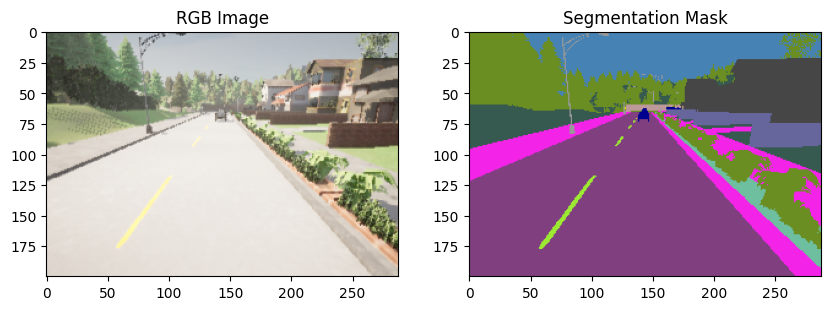

In [ ]:
def visualize_sample(data, frame_idx=0):
    # Select frame
    rgb_image = data['rgb'][frame_idx]
    seg_image = data['segmentation'][frame_idx]

    # Convert RGB to displayable image
    rgb_image = Image.fromarray(rgb_image.astype('uint8'))

    # Plot RGB and Segmentation side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(rgb_image)
    axs[0].set_title('RGB Image')

    axs[1].imshow(seg_image)
    axs[1].set_title('Segmentation Mask')

    plt.show()

# Visualize sample frame
visualize_sample(episode_data, frame_idx=0)


## Step 3: Preprocessing

### 3.1: Normalize Control Values

In [ ]:
def normalize_controls(controls):
    # Normalize the control values to the range [0, 1] (if not already)
    controls[:, 0] = controls[:, 0] / np.max(controls[:, 0])  # throttle
    controls[:, 1] = (controls[:, 1] + 1) / 2  # steer [-1, 1] -> [0, 1]
    controls[:, 2] = controls[:, 2] / np.max(controls[:, 2])  # brake
    return controls

# Normalize control values
episode_data['controls'] = normalize_controls(episode_data['controls'])


### 3.2: Normalize Speed (Measurements)

In [ ]:
def normalize_speed(speed):
    max_speed = 100  # Assuming 100 km/h as max speed
    return speed / max_speed

# Normalize speed
episode_data['measurements'] = normalize_speed(episode_data['measurements'])


### 3.3: Resize Images

In [ ]:
from torchvision import transforms

def resize_images(images, size=(128, 128)):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    resized_images = np.array([transform(img) for img in images])
    return resized_images

# Resize RGB and Segmentation images
episode_data['rgb'] = resize_images(episode_data['rgb'])
episode_data['segmentation'] = resize_images(episode_data['segmentation'])


## Step 4: Batching and Dataloader Setup

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom PyTorch Dataset
class CARLADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['frame'])

    def __getitem__(self, idx):
        rgb = torch.tensor(self.data['rgb'][idx], dtype=torch.float32)
        segmentation = torch.tensor(self.data['segmentation'][idx], dtype=torch.float32)
        controls = torch.tensor(self.data['controls'][idx], dtype=torch.float32)
        speed = torch.tensor(self.data['measurements'][idx], dtype=torch.float32)
        hlc = torch.tensor(self.data['hlc'][idx], dtype=torch.int64)
        light = torch.tensor(self.data['light'][idx], dtype=torch.int64)

        return rgb, segmentation, controls, speed, hlc, light

# Create dataset and DataLoader
carla_dataset = CARLADataset(episode_data)
carla_dataloader = DataLoader(carla_dataset, batch_size=32, shuffle=True)


# Loading and Analyzing the data: version 2

In [ ]:
import h5py
import numpy as np

# Load the HDF5 episode file
file_path = 'episode_0.hdf5'

with h5py.File(file_path, 'r') as f:
    # Extract individual components
    frame_indices = list(f['frame'])  # Frame indices
    hlc = np.array(f['hlc'])  # High-level commands
    lights = np.array(f['light'])  # Traffic light status
    controls = np.array(f['controls'])  # Throttle, Steer, Brake
    speed = np.array(f['measurements'])  # Current speed in km/h
    rgb_images = np.array(f['rgb'])  # RGB camera images
    segmentation_images = np.array(f['segmentation'])  # Ground truth segmentation

# Print the shapes of data to verify
print("Frame indices:", len(frame_indices))
print("HLC:", hlc.shape)
print("Traffic lights:", lights.shape)
print("Controls:", controls.shape)
print("Speed:", speed.shape)
print("RGB Images:", rgb_images.shape)
print("Segmentation Images:", segmentation_images.shape)


Frame indices: 1419
HLC: (1419, 1)
Traffic lights: (1419, 1)
Controls: (1419, 3)
Speed: (1419, 1)
RGB Images: (1419, 200, 288, 3)
Segmentation Images: (1419, 200, 288, 3)


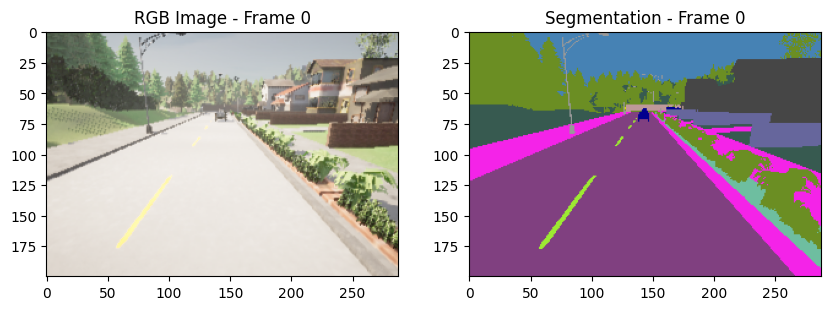

In [ ]:
import matplotlib.pyplot as plt

# Function to display RGB and segmentation side by side for a specific frame
def display_frame(frame_index):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Show RGB image
    ax[0].imshow(rgb_images[frame_index])
    ax[0].set_title(f'RGB Image - Frame {frame_index}')

    # Show Segmentation image
    ax[1].imshow(segmentation_images[frame_index])
    ax[1].set_title(f'Segmentation - Frame {frame_index}')

    plt.show()

# Display the first frame (frame 0)
display_frame(0)


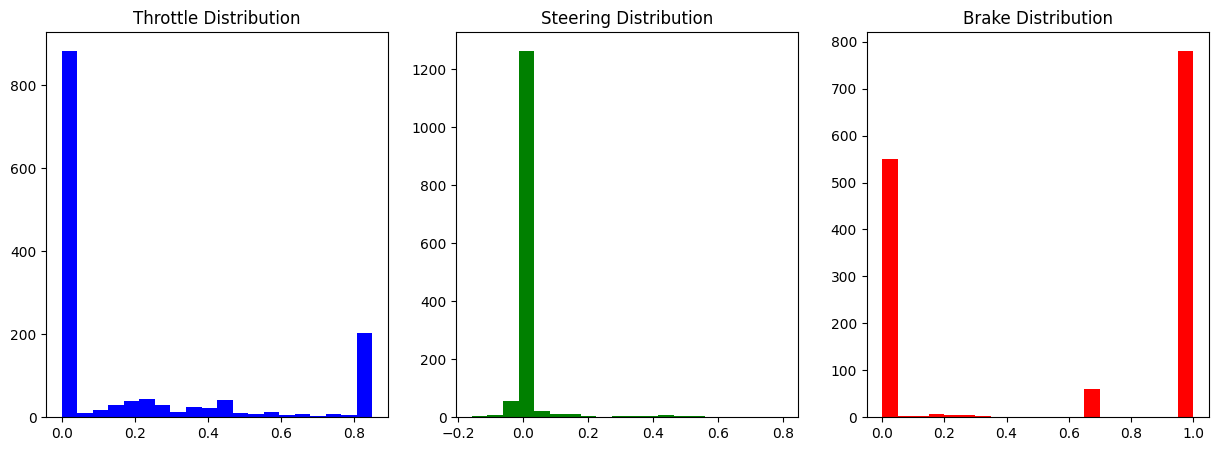

In [ ]:
# Plot distribution of throttle, steer, and brake
def plot_control_distribution():
    throttle = controls[:, 0]
    steer = controls[:, 1]
    brake = controls[:, 2]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].hist(throttle, bins=20, color='blue')
    ax[0].set_title('Throttle Distribution')

    ax[1].hist(steer, bins=20, color='green')
    ax[1].set_title('Steering Distribution')

    ax[2].hist(brake, bins=20, color='red')
    ax[2].set_title('Brake Distribution')

    plt.show()

plot_control_distribution()


In [ ]:
import cv2

def resize_images(images, new_size=(128, 128)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

# Resize RGB and segmentation images
rgb_resized = resize_images(rgb_images, new_size=(128, 128))
segmentation_resized = resize_images(segmentation_images, new_size=(128, 128))

# Check shape
print("Resized RGB Images shape:", rgb_resized.shape)
print("Resized Segmentation Images shape:", segmentation_resized.shape)


Resized RGB Images shape: (1419, 128, 128, 3)
Resized Segmentation Images shape: (1419, 128, 128, 3)


In [ ]:
# Normalize RGB images (convert pixel values to range 0-1)
rgb_normalized = rgb_resized / 255.0

# Normalize controls (optional, depending on the value range)
controls_normalized = controls / np.array([1.0, 1.0, 1.0])  # Assuming throttle, steer, brake are between 0 and 1

# Print shape and verify values
print("Normalized RGB Images shape:", rgb_normalized.shape)
print("First normalized RGB pixel value:", rgb_normalized[0][0][0])


Normalized RGB Images shape: (1419, 128, 128, 3)
First normalized RGB pixel value: [0.29411765 0.34117647 0.28235294]


In [ ]:
from sklearn.model_selection import train_test_split

# Define the features (X) and labels (y)
X = rgb_normalized
y = controls_normalized  # Labels can be controls for now (throttle, steer, brake)

# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (1135, 128, 128, 3) (1135, 3)
Testing data shape: (284, 128, 128, 3) (284, 3)


In [ ]:
def normalize_controls(controls):
    throttle = controls[0]  # Already between 0 and 1
    steer = (controls[1] + 1) / 2  # Normalize steer to range [0, 1]
    brake = controls[2]  # Already between 0 and 1
    return torch.tensor([throttle, steer, brake], dtype=torch.float32)

for data in dataset:
    img = data[0]  # Normalized image (RGB + Segmentation)
    speed = data[1]  # Speed measurement
    hlc = data[2]  # High-level command (HLC)
    light = data[3]  # Traffic light status
    controls = data[4]  # Normalized controls

    # Check the shape and range of the concatenated image
    print(f"Image shape: {img.shape}")
    print(f"Image min: {img.min()}, max: {img.max()}")  # Should be [0, 1] range

    break




Image shape: torch.Size([6, 200, 288])
Image min: 0.0, max: 1.0


# Step by Step

## Loading

In [ ]:
import requests
import h5py
import io

# Load HDF5 file from a URL
def load_hdf5_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad responses
    return h5py.File(io.BytesIO(response.content), 'r')

# URL of the HDF5 file
hdf5_url = 'https://huggingface.co/datasets/nightmare-nectarine/segmentation-carla-driving/resolve/main/train/episode_0.hdf5'
hdf5_file = load_hdf5_from_url(hdf5_url)


## EDA

### Inspecting the Data Structure

In [ ]:
# Inspect the structure of the HDF5 file
def inspect_hdf5_file(hdf5_file):
    print("Keys in the HDF5 file:")
    for key in hdf5_file.keys():
        print(key)
    print("\nDetails of each group:")
    for key in hdf5_file.keys():
        print(f"Group: {key}, Shape: {hdf5_file[key][:].shape}, Type: {hdf5_file[key].dtype}")

inspect_hdf5_file(hdf5_file)


Keys in the HDF5 file:
controls
frame
hlc
light
measurements
rgb
segmentation

Details of each group:
Group: controls, Shape: (1419, 3), Type: float64
Group: frame, Shape: (1419, 1), Type: int64
Group: hlc, Shape: (1419, 1), Type: int64
Group: light, Shape: (1419, 1), Type: int64
Group: measurements, Shape: (1419, 1), Type: float64
Group: rgb, Shape: (1419, 200, 288, 3), Type: uint8
Group: segmentation, Shape: (1419, 200, 288, 3), Type: uint8


### Visual Analysis

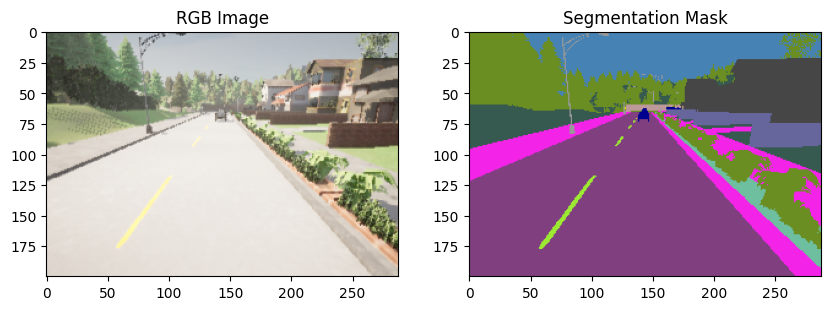

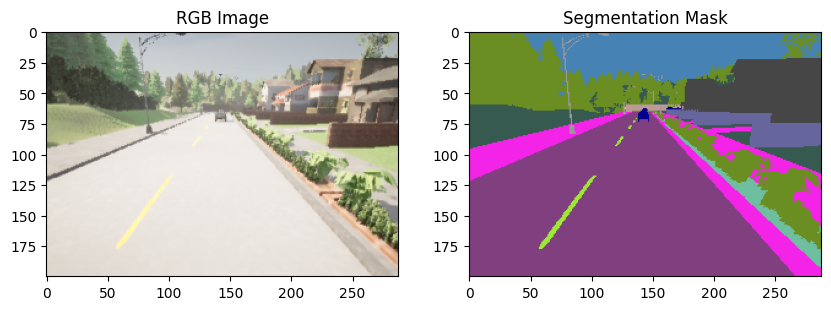

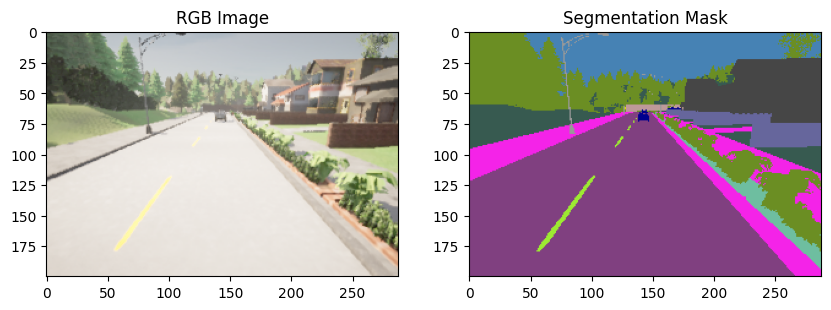

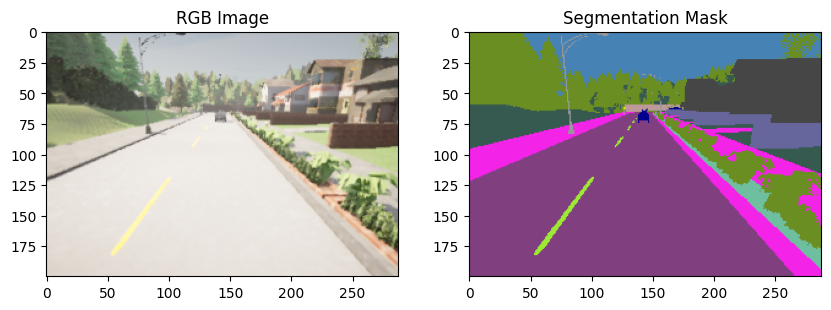

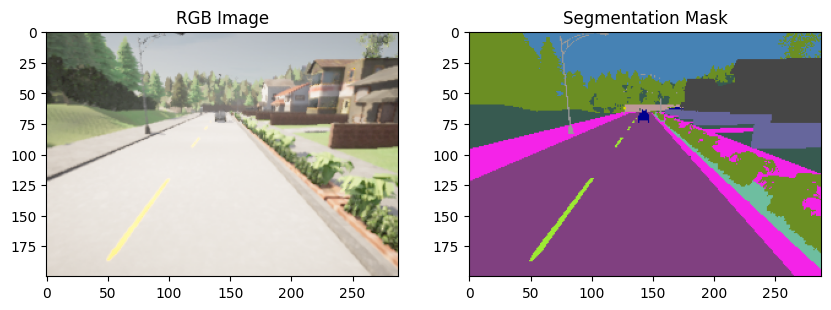

In [ ]:
import matplotlib.pyplot as plt

def visualize_samples(hdf5_file, num_samples=5):
    rgb_images = hdf5_file['rgb'][:num_samples]
    segmentation_masks = hdf5_file['segmentation'][:num_samples]

    for i in range(num_samples):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("RGB Image")
        plt.imshow(rgb_images[i])

        plt.subplot(1, 2, 2)
        plt.title("Segmentation Mask")
        plt.imshow(segmentation_masks[i])

        plt.show()

visualize_samples(hdf5_file)


## Data Preprocessing

### Normalization and Resizing

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

def preprocess_data(hdf5_file, image_size=(128, 128)):
    rgb_images = hdf5_file['rgb'][:]
    segmentation_masks = hdf5_file['segmentation'][:]

    # Normalize RGB images
    rgb_images = rgb_images.astype(np.float32) / 255.0

    # Resize images and masks
    rgb_images_resized = np.array([cv2.resize(img, image_size) for img in rgb_images])
    segmentation_masks_resized = np.array([cv2.resize(mask, image_size) for mask in segmentation_masks])

    # Split dataset into training and testing sets
    X_train_rgb, X_test_rgb, y_train_seg, y_test_seg = train_test_split(rgb_images_resized, segmentation_masks_resized, test_size=0.2, random_state=42)

    return X_train_rgb, X_test_rgb, y_train_seg, y_test_seg

# Call the preprocessing function
X_train_rgb, X_test_rgb, y_train_seg, y_test_seg = preprocess_data(hdf5_file)


### Handling Control Inputs

In [ ]:
def preprocess_controls(hdf5_file):
    controls = hdf5_file['controls'][:]

    controls_normalized = controls / np.max(np.abs(controls), axis=0)  # Normalizing based on max value
    return controls_normalized

# Process controls
controls_normalized = preprocess_controls(hdf5_file)


## Feature Engineering

### A. Feature Extraction Techniques

* Image Features: Use pre-trained models (like VGG16) for transfer learning.
* Control Features: Extract mean, variance, and other statistical metrics from control inputs.

In [ ]:
from tensorflow.keras.applications import VGG16

def extract_image_features(images):
    model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    features = model.predict(images)
    return features

# Extract features from training images
image_features_train = extract_image_features(X_train_rgb)
image_features_test = extract_image_features(X_test_rgb)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 631ms/step


## Model Development For FL

## A. Local Model Architecture

Design a local model that can handle diverse input types (images and controls):

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Concatenate, Dropout, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

def create_local_model(image_shape, control_shape):
    # Image input
    image_input = Input(shape=image_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Control input
    control_input = Input(shape=control_shape)
    y = Dense(64, activation='relu')(control_input)

    # Combine features
    combined = Concatenate()([x, y])
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)

    # Output layer for RGB segmentation
    output = Dense(np.prod((image_shape[0], image_shape[1], 3)), activation='sigmoid')(z)  # 3 for RGB
    output = Reshape((image_shape[0], image_shape[1], 3))(output)

    model = Model(inputs=[image_input, control_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define model shape parameters
image_shape = (128, 128, 3)
control_shape = (controls_normalized.shape[1],)  # Number of control inputs

local_model = create_local_model(image_shape, control_shape)


In [ ]:
control_shape, controls_normalized

((3,),
 array([[ 1.        ,  0.01897364,  0.        ],
        [ 1.        ,  0.01888431,  0.        ],
        [ 1.        ,  0.01780159,  0.        ],
        ...,
        [ 0.22982642, -0.00841054,  0.        ],
        [ 0.28049912, -0.00738034,  0.        ],
        [ 0.2235176 , -0.00629405,  0.        ]]))

## Training and Evaluation

### A. Local Model Training

Train the local model using the training data and evaluate its performance:

In [ ]:
history = local_model.fit([X_train_rgb, controls_normalized[:X_train_rgb.shape[0]]], y_train_seg,
                          validation_split=0.2, epochs=1, batch_size=32)


29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 939ms/step - accuracy: 0.4092 - loss: 16534.9395 - val_accuracy: 0.3339 - val_loss: 16608.4355


In [ ]:
# Evaluate the model
test_loss, test_accuracy = local_model.evaluate(
    [X_test_rgb, controls_normalized[:X_test_rgb.shape[0]]],
    y_test_seg
)
print(f'Test Accuracy: {test_accuracy:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 690ms/step - accuracy: 0.3339 - loss: 16555.3438
Test Accuracy: 0.33


### B. Aggregating Global Model

The global model can be updated by aggregating local model weights:

In [ ]:
import numpy as np
from tensorflow.keras.models import Model

def aggregate_models(local_models):
    """
    Aggregate weights of local models into a global model.

    Args:
        local_models (list): List of Keras models representing the local models.

    Returns:
        global_model (Model): A new Keras model representing the aggregated global model.
    """
    # Check if there are any local models
    if not local_models:
        raise ValueError("No local models provided for aggregation.")

    # Get the weights of the first model to create the global model
    global_model_weights = local_models[0].get_weights()

    # Initialize a weight sum for each layer
    weight_sum = [np.zeros_like(w) for w in global_model_weights]

    # Sum the weights from each local model
    for model in local_models:
        local_weights = model.get_weights()
        for i in range(len(weight_sum)):
            weight_sum[i] += local_weights[i]

    # Average the weights
    num_models = len(local_models)
    averaged_weights = [w / num_models for w in weight_sum]

    # Create a new global model (using the same architecture as local models)
    global_model = Model(inputs=local_models[0].input, outputs=local_models[0].output)
    global_model.set_weights(averaged_weights)

    return global_model


local_models = [local_model]
global_model = aggregate_models(local_models)

global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Evaluate the model
test_loss, test_accuracy = global_model.evaluate(
    [X_test_rgb, controls_normalized[:X_test_rgb.shape[0]]],
    y_test_seg
)
print(f'Test Accuracy: {test_accuracy:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.3339 - loss: 387.8102
Test Accuracy: 0.33


# Multiple Local Models

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

def preprocess_data(hdf5_file, image_size=(128, 128)):
    # Load RGB images and segmentation masks
    rgb_images = hdf5_file['rgb'][:]
    segmentation_masks = hdf5_file['segmentation'][:]

    # Load control data
    controls = hdf5_file['controls'][:]

    # Normalize RGB images
    rgb_images = rgb_images.astype(np.float32) / 255.0

    # Resize images and masks
    rgb_images_resized = np.array([cv2.resize(img, image_size) for img in rgb_images])
    segmentation_masks_resized = np.array([cv2.resize(mask, image_size) for mask in segmentation_masks])

    # Normalize controls
    controls_normalized = controls / np.max(np.abs(controls), axis=0)  # Normalize controls

    # Split dataset into training and testing sets (80% training, 20% testing)
    X_train_rgb, X_test_rgb, y_train_seg, y_test_seg, controls_train, controls_test = train_test_split(
        rgb_images_resized,
        segmentation_masks_resized,
        controls_normalized,
        test_size=0.2,
        random_state=42
    )

    # Further split the training data into 3 parts for local models
    X_train_rgb_1, X_train_rgb_temp, y_train_seg_1, y_train_seg_temp, controls_model_1, controls_temp = train_test_split(
        X_train_rgb, y_train_seg, controls_train, test_size=0.30, random_state=42
    )  # 30% for temp, leaving 70% for the first local model

    X_train_rgb_2, X_train_rgb_3, y_train_seg_2, y_train_seg_3, controls_model_2, controls_model_3 = train_test_split(
        X_train_rgb_temp, y_train_seg_temp, controls_temp, test_size=0.5, random_state=42
    )  # Split the temp data into two parts

    return (
        X_train_rgb_1, X_train_rgb_2, X_train_rgb_3,
        X_test_rgb, y_train_seg_1, y_train_seg_2, y_train_seg_3,
        y_test_seg, controls_model_1, controls_model_2, controls_model_3
    )

# Call the preprocessing function
X_train_rgb_1, X_train_rgb_2, X_train_rgb_3, X_test_rgb, y_train_seg_1, y_train_seg_2, y_train_seg_3, y_test_seg, controls_model_1, controls_model_2, controls_model_3 = preprocess_data(hdf5_file)

# Check the shapes to ensure everything is correctly split
print(f"Model 1 Training Data: {X_train_rgb_1.shape}, {y_train_seg_1.shape}, Control: {controls_model_1.shape}")
print(f"Model 2 Training Data: {X_train_rgb_2.shape}, {y_train_seg_2.shape}, Control: {controls_model_2.shape}")
print(f"Model 3 Training Data: {X_train_rgb_3.shape}, {y_train_seg_3.shape}, Control: {controls_model_3.shape}")
print(f"Test Data: {X_test_rgb.shape}, {y_test_seg.shape}")


NameError: name 'hdf5_file' is not defined

In [ ]:
# Extract features from training images
image_features_train_1 = extract_image_features(X_train_rgb_1)
image_features_train_2 = extract_image_features(X_train_rgb_2)
image_features_train_3 = extract_image_features(X_train_rgb_3)

image_features_test = extract_image_features(X_test_rgb)

In [ ]:
def create_local_model(image_shape, control_shape):
    # Image input
    image_input = Input(shape=image_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Control input
    control_input = Input(shape=control_shape)
    y = Dense(64, activation='relu')(control_input)

    # Combine features
    combined = Concatenate()([x, y])
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z)

    # Output layer for RGB segmentation
    output = Dense(np.prod((image_shape[0], image_shape[1], 3)), activation='sigmoid')(z)  # 3 for RGB
    output = Reshape((image_shape[0], image_shape[1], 3))(output)

    model = Model(inputs=[image_input, control_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])
    return model

In [ ]:
from keras.backend import clear_session

local_models = [
    create_local_model(image_shape, control_shape),  # Model 1
    create_local_model(image_shape, control_shape),  # Model 2
    create_local_model(image_shape, control_shape)   # Model 3
]

for i, model in enumerate(local_models):
    model.fit(
        [X_train_rgb_1, controls_model_1] if i == 0 else
        [X_train_rgb_2, controls_model_2] if i == 1 else
        [X_train_rgb_3, controls_model_3],
        [y_train_seg_1 if i == 0 else
         y_train_seg_2 if i == 1 else
         y_train_seg_3],
        epochs=5,
        batch_size=16
    )
    print(f"Model {i + 1} training complete.")
    clear_session()

In [ ]:
global_model = aggregate_models(local_models)

global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Evaluate the model
test_loss, test_accuracy = global_model.evaluate(
    [X_test_rgb, controls_normalized[:X_test_rgb.shape[0]]],
    y_test_seg
)
print(f'Test Accuracy: {test_accuracy:.2f}')

In [ ]:
lm1 = create_local_model(image_shape, control_shape) # Model 1
lm2 =  create_local_model(image_shape, control_shape)  # Model 2
lm3 = create_local_model(image_shape, control_shape)   # Model 3

# Train Model 1
lm1.fit(
    [X_train_rgb_1, controls_model_1],
    y_train_seg_1,
    epochs=1,
    batch_size=32
)
print("Model 1 training complete.")
clear_session()  # Clear memory

# Train Model 2
lm2.fit(
    [X_train_rgb_2, controls_model_2],
    y_train_seg_2,
    epochs=1,
    batch_size=32
)
print("Model 2 training complete.")
clear_session()

# Train Model 3
lm3.fit(
    [X_train_rgb_3, controls_model_3],
    y_train_seg_3,
    epochs=1,
    batch_size=32
)
print("Model 3 training complete.")
clear_session()

# Helper Functions

In [2]:
import requests
import h5py
import io

# Load HDF5 file from a URL
def load_hdf5_from_url(url, number_of_episodes=1):
    hdf5_files = []
    for episode_number in range(number_of_episodes):
      new_url = url + f'episode_{episode_number}.hdf5'
      response = requests.get(new_url)
      response.raise_for_status()  # Raise an error for bad responses
      hdf5_files.append(h5py.File(io.BytesIO(response.content), 'r'))
      print(f"episode_{episode_number}.hdf5 loaded successfully.")
    return hdf5_files

hdf5_url = 'https://huggingface.co/datasets/nightmare-nectarine/segmentation-carla-driving/resolve/main/train/'
hdf5_files = load_hdf5_from_url(hdf5_url, 6)


episode_0.hdf5 loaded successfully.
episode_1.hdf5 loaded successfully.
episode_2.hdf5 loaded successfully.
episode_3.hdf5 loaded successfully.
episode_4.hdf5 loaded successfully.
episode_5.hdf5 loaded successfully.


In [3]:
len(hdf5_files)

6

In [12]:
import h5py

# Explore the HDF5 file structure to see what datasets are present
def explore_hdf5_structure(hdf5_file):
    """
    Print the structure and contents of an HDF5 file to explore available datasets.
    """
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Type: {obj.dtype}")

    hdf5_file.visititems(print_structure)

# Check each episode file's structure
for episode_file in hdf5_files:
    print("Exploring HDF5 structure:")
    explore_hdf5_structure(episode_file)


Exploring HDF5 structure:
Dataset: controls, Shape: (1419, 3), Type: float64
Dataset: frame, Shape: (1419, 1), Type: int64
Dataset: hlc, Shape: (1419, 1), Type: int64
Dataset: light, Shape: (1419, 1), Type: int64
Dataset: measurements, Shape: (1419, 1), Type: float64
Dataset: rgb, Shape: (1419, 200, 288, 3), Type: uint8
Dataset: segmentation, Shape: (1419, 200, 288, 3), Type: uint8
Exploring HDF5 structure:
Dataset: controls, Shape: (1330, 3), Type: float64
Dataset: frame, Shape: (1330, 1), Type: int64
Dataset: hlc, Shape: (1330, 1), Type: int64
Dataset: light, Shape: (1330, 1), Type: int64
Dataset: measurements, Shape: (1330, 1), Type: float64
Dataset: rgb, Shape: (1330, 200, 288, 3), Type: uint8
Dataset: segmentation, Shape: (1330, 200, 288, 3), Type: uint8
Exploring HDF5 structure:
Dataset: controls, Shape: (2439, 3), Type: float64
Dataset: frame, Shape: (2439, 1), Type: int64
Dataset: hlc, Shape: (2439, 1), Type: int64
Dataset: light, Shape: (2439, 1), Type: int64
Dataset: measurem

In [4]:
def inspect_hdf5_file(hdf5_file, file_number):
    # print("Keys in the HDF5 file:")
    # for key in hdf5_file.keys():
    #     print(key)
    print(f"\nDetails of episode {file_number}: ")
    for key in hdf5_file.keys():
        print(f"Group: {key}, Shape: {hdf5_file[key][:].shape}, Type: {hdf5_file[key].dtype}")

# for file_number, hdf5_file in enumerate(hdf5_files):
#     inspect_hdf5_file(hdf5_file, file_number)
#     print()

In [5]:
import numpy as np
import cv2

def preprocess_rgb_segmentation_multiple_episodes(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing episode data by normalizing and resizing the images and masks.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'rgb' and 'segmentation' datasets.
    - image_size: Target size for resizing the images and segmentation masks.

    Returns:
    - rgb_images_combined: Combined RGB images from all episodes.
    - segmentation_masks_combined: Combined segmentation masks from all episodes.
    """
    rgb_images_combined = []
    segmentation_masks_combined = []

    # Loop through each HDF5 file and concatenate the datasets
    for hdf5_file in hdf5_files:
        rgb_images = hdf5_file['rgb'][:]
        segmentation_masks = hdf5_file['segmentation'][:]

        # Normalize RGB images
        rgb_images = rgb_images.astype(np.float32) / 255.0

        # Resize images and masks
        rgb_images_resized = np.array([cv2.resize(img, image_size) for img in rgb_images])
        segmentation_masks_resized = np.array([cv2.resize(mask, image_size) for mask in segmentation_masks])

        # Append to combined lists
        rgb_images_combined.append(rgb_images_resized)
        segmentation_masks_combined.append(segmentation_masks_resized)

    # Concatenate all episodes into a single dataset
    rgb_images_combined = np.concatenate(rgb_images_combined, axis=0)
    segmentation_masks_combined = np.concatenate(segmentation_masks_combined, axis=0)

    return rgb_images_combined, segmentation_masks_combined

# rgb_data, segmentation_data = preprocess_rgb_segmentation_multiple_episodes(hdf5_files)

# Output shapes for verification
# print(f"Combined RGB images shape: {rgb_data.shape}")
# print(f"Combined Segmentation masks shape: {segmentation_data.shape}")


import numpy as np
import cv2

def preprocess_rgb_images(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing RGB images by normalizing and resizing them.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'rgb' dataset.
    - image_size: Target size for resizing the images.

    Returns:
    - rgb_images_combined: Combined and preprocessed RGB images from all episodes.
    """
    rgb_images_combined = []

    # Loop through each HDF5 file and process the RGB images
    for hdf5_file in hdf5_files:
        rgb_images = hdf5_file['rgb'][:]

        # Normalize RGB images
        rgb_images = rgb_images.astype(np.float32) / 255.0

        # Resize images
        rgb_images_resized = np.array([cv2.resize(img, image_size) for img in rgb_images])

        # Append to combined list
        rgb_images_combined.append(rgb_images_resized)

    # Concatenate all episodes into a single dataset
    rgb_images_combined = np.concatenate(rgb_images_combined, axis=0)

    return rgb_images_combined


def preprocess_segmentation_masks(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing segmentation masks by resizing them.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'segmentation' dataset.
    - image_size: Target size for resizing the masks.

    Returns:
    - segmentation_masks_combined: Combined and preprocessed segmentation masks from all episodes.
    """
    segmentation_masks_combined = []

    # Loop through each HDF5 file and process the segmentation masks
    for hdf5_file in hdf5_files:
        segmentation_masks = hdf5_file['segmentation'][:]

        # Resize masks
        segmentation_masks_resized = np.array([cv2.resize(mask, image_size) for mask in segmentation_masks])

        # Append to combined list
        segmentation_masks_combined.append(segmentation_masks_resized)

    # Concatenate all episodes into a single dataset
    segmentation_masks_combined = np.concatenate(segmentation_masks_combined, axis=0)

    return segmentation_masks_combined


# Call the functions
rgb_data = preprocess_rgb_images(hdf5_files)
segmentation_data = preprocess_segmentation_masks(hdf5_files)

# Output shapes for verification
print(f"Combined RGB images shape: {rgb_data.shape}")
print(f"Combined Segmentation masks shape: {segmentation_data.shape}")


Combined RGB images shape: (9535, 128, 128, 3)
Combined Segmentation masks shape: (9535, 128, 128, 3)


In [6]:
import numpy as np

def preprocess_controls_multiple_episodes(hdf5_files):
    """
    Preprocess control data from multiple HDF5 files by concatenating and normalizing the controls.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'controls' dataset.

    Returns:
    - controls_normalized: Combined and normalized control data from all episodes.
    """
    controls_combined = []

    # Loop through each HDF5 file and concatenate the controls data
    for hdf5_file in hdf5_files:
        controls = hdf5_file['controls'][:]
        controls_combined.append(controls)

    # Concatenate all episodes' controls data
    controls_combined = np.concatenate(controls_combined, axis=0)

    # Normalize controls based on the max absolute value per feature
    controls_normalized = controls_combined / np.max(np.abs(controls_combined), axis=0)

    return controls_normalized

controls_normalized = preprocess_controls_multiple_episodes(hdf5_files)


In [7]:
import numpy as np

def preprocess_frames_multiple_episodes(hdf5_files):
    """
    Preprocess frame data from multiple HDF5 files by concatenating the frames.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'frame' dataset.

    Returns:
    - frames_combined: Combined frame data from all episodes.
    """
    frames_combined = []

    for hdf5_file in hdf5_files:
        frames = hdf5_file['frame'][:]
        frames_combined.append(frames)

    frames_combined = np.concatenate(frames_combined, axis=0)
    return frames_combined


def preprocess_hlc_multiple_episodes(hdf5_files):
    """
    Preprocess high-level command (hlc) data from multiple HDF5 files by concatenating the hlc data.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'hlc' dataset.

    Returns:
    - hlc_combined: Combined hlc data from all episodes.
    """
    hlc_combined = []

    for hdf5_file in hdf5_files:
        hlc = hdf5_file['hlc'][:]
        hlc_combined.append(hlc)

    hlc_combined = np.concatenate(hlc_combined, axis=0)
    return hlc_combined


def preprocess_light_multiple_episodes(hdf5_files):
    """
    Preprocess light data from multiple HDF5 files by concatenating the light data.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'light' dataset.

    Returns:
    - light_combined: Combined light data from all episodes.
    """
    light_combined = []

    for hdf5_file in hdf5_files:
        light = hdf5_file['light'][:]
        light_combined.append(light)

    light_combined = np.concatenate(light_combined, axis=0)
    return light_combined


def preprocess_measurements_multiple_episodes(hdf5_files):
    """
    Preprocess measurement data from multiple HDF5 files by concatenating the measurements.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'measurements' dataset.

    Returns:
    - measurements_combined: Combined measurement data from all episodes.
    """
    measurements_combined = []

    for hdf5_file in hdf5_files:
        measurements = hdf5_file['measurements'][:]
        measurements_combined.append(measurements)

    measurements_combined = np.concatenate(measurements_combined, axis=0)
    return measurements_combined

# Process all datasets
controls_normalized = preprocess_controls_multiple_episodes(hdf5_files)
frame_data = preprocess_frames_multiple_episodes(hdf5_files)
hlc_data = preprocess_hlc_multiple_episodes(hdf5_files)
light_data = preprocess_light_multiple_episodes(hdf5_files)
measurements_data = preprocess_measurements_multiple_episodes(hdf5_files)

# Output shapes for verification
print(f"Controls shape: {controls_normalized.shape}")
print(f"Frames shape: {frame_data.shape}")
print(f"HLC shape: {hlc_data.shape}")
print(f"Light shape: {light_data.shape}")
print(f"Measurements shape: {measurements_data.shape}")


Controls shape: (9535, 3)
Frames shape: (9535, 1)
HLC shape: (9535, 1)
Light shape: (9535, 1)
Measurements shape: (9535, 1)


In [8]:

import numpy as np

def split_data_for_models_multiple_types(data_dict, num_models, data_distribution, data_types=None, random_seed=None):
    """
    Split the preprocessed data into subsets for local models based on the specified distribution.

    Parameters:
    - data_dict: Dictionary containing various preprocessed data types (X, y, etc.).
    - num_models: Number of local models to be implemented.
    - data_distribution: List of proportions for each model's training data.
    - data_types: List of data types to include in the split. If None, all data types are used.
    - random_seed: Seed for reproducibility of data splits.

    Returns:
    - model_data: Dictionary containing training data for each model.
    """

    # Validate inputs
    if len(data_distribution) != num_models:
        raise ValueError("Length of data_distribution must match num_models.")
    if not np.isclose(np.sum(data_distribution), 1.0):
        raise ValueError("Data distribution must sum to 1.")

    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    model_data = {}
    total_samples = len(data_dict['rgb'])  # Assumes all data types have the same length

    # If data_types is None, use all keys from data_dict
    if data_types is None:
        data_types = data_dict.keys()

    # Validate that all data types have the same number of samples
    for key in data_types:
        if key in data_dict and len(data_dict[key]) != total_samples:
            raise ValueError(f"Data type '{key}' has inconsistent sample size.")

    indices = np.arange(total_samples)
    np.random.shuffle(indices)  # Shuffle indices for randomness

    start_idx = 0
    for model_id in range(num_models):
        # Calculate the number of samples for the current model
        num_samples = int(data_distribution[model_id] * total_samples)
        if model_id == num_models - 1:  # Last model gets any leftover data
            num_samples = total_samples - start_idx

        model_data[f'model_{model_id + 1}'] = {
            key: np.array([data_dict[key][i] for i in indices[start_idx:start_idx + num_samples]])
            for key in data_types if key in data_dict
        }

        start_idx += num_samples

    return model_data

# Example usage
data_dict = {
    'controls': controls_normalized,
    'frame': frame_data,
    'hlc': hlc_data,
    'light': light_data,
    'measurements': measurements_data,
    'rgb': rgb_data,
    'segmentation': segmentation_data,
}

# Specify the number of local models, data distribution, and types to include
num_local_models = 3
data_distribution = [0.4, 0.4, 0.2]
data_types_to_include = ['rgb', 'segmentation', 'hlc', 'light', 'measurements']

# Split the data for selected types
model_data = split_data_for_models_multiple_types(data_dict, num_local_models, data_distribution, data_types=data_types_to_include, random_seed=42)

# Output shapes for verification
for model_id, data in model_data.items():
    print(f"{model_id} - Data shapes:")
    for key, value in data.items():
        print(f"  {key}: {value.shape}")


model_1 - Data shapes:
  rgb: (3814, 128, 128, 3)
  segmentation: (3814, 128, 128, 3)
  hlc: (3814, 1)
  light: (3814, 1)
  measurements: (3814, 1)
model_2 - Data shapes:
  rgb: (3814, 128, 128, 3)
  segmentation: (3814, 128, 128, 3)
  hlc: (3814, 1)
  light: (3814, 1)
  measurements: (3814, 1)
model_3 - Data shapes:
  rgb: (1907, 128, 128, 3)
  segmentation: (1907, 128, 128, 3)
  hlc: (1907, 1)
  light: (1907, 1)
  measurements: (1907, 1)


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Defining the model architecture
def create_model(input_shapes):
    """
    Create a multi-input model based on the shapes of the input data.

    Parameters:
    - input_shapes: Dictionary containing the shape of each input type (e.g., 'rgb', 'segmentation', etc.)

    Returns:
    - A compiled Keras model with multiple inputs.
    """
    # Input layers for each type of data
    rgb_input = Input(shape=input_shapes['rgb'], name='rgb_input')
    seg_input = Input(shape=input_shapes['segmentation'], name='seg_input')
    hlc_input = Input(shape=input_shapes['hlc'], name='hlc_input')
    light_input = Input(shape=input_shapes['light'], name='light_input')
    measurements_input = Input(shape=input_shapes['measurements'], name='measurements_input')

    # Simple CNN for RGB and Segmentation inputs
    rgb_features = layers.Conv2D(32, (3, 3), activation='relu')(rgb_input)
    rgb_features = layers.MaxPooling2D((2, 2))(rgb_features)
    rgb_features = layers.Flatten()(rgb_features)

    seg_features = layers.Conv2D(32, (3, 3), activation='relu')(seg_input)
    seg_features = layers.MaxPooling2D((2, 2))(seg_features)
    seg_features = layers.Flatten()(seg_features)

    # Dense layers for other inputs
    hlc_features = layers.Dense(16, activation='relu')(hlc_input)
    light_features = layers.Dense(16, activation='relu')(light_input)
    measurements_features = layers.Dense(16, activation='relu')(measurements_input)

    # Concatenate all features
    concatenated = layers.concatenate([rgb_features, seg_features, hlc_features, light_features, measurements_features])

    # Output layer (adjust depending on your task, e.g., classification, regression)
    output = layers.Dense(1, activation='sigmoid')(concatenated)

    # Create model
    model = Model(inputs=[rgb_input, seg_input, hlc_input, light_input, measurements_input], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [11]:
# Now, train local models on their respective datasets
local_models = []
for model_id, data in model_data.items():
    print(f"Training {model_id}...")

    # Get the shapes of the inputs
    input_shapes = {key: data[key].shape[1:] for key in data_types_to_include}

    # Create a model for this data
    model = create_model(input_shapes)

    # Train the model (placeholder example using dummy labels)
    labels = np.random.randint(0, 2, size=(len(data['rgb']),))  # Assuming binary labels

    model.fit(
        [data['rgb'], data['segmentation'], data['hlc'], data['light'], data['measurements']],
        labels, epochs=10, batch_size=16
    )

    local_models.append(model)
    print(f"{model_id} training complete.\n")

Training model_1...
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4737 - loss: 280.9557
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5701 - loss: 1.0772
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6347 - loss: 0.7992
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6920 - loss: 0.6912
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7202 - loss: 0.6564
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7493 - loss: 0.5579
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7698 - loss: 0.5408
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8076 - loss: 0.4752
Epoch 9/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7932 - loss: 0.4801
Epoch 10/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8083 - loss: 0.4395
model_1 training complete.

Training model_2...
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4